# Construindo uma Rede Neural e Visualizando o Forward Pass

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/fabiobento/dnn-course-2026-1/blob/main/aulas/dl-pytorch/intro-dl/docs/first-nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/fabiobento/dnn-course-2026-1/blob/main/aulas/dl-pytorch/intro-dl/docs/first-nn.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

Neste laboratório, vamos construir uma rede neural do zero usando PyTorch.

Ao final, você saberá como criar sua própria rede neural com apenas algumas linhas de código, entenderá como um forward pass transforma entradas em previsões e visualizará como sua rede toma decisões.

## Passo 1: Configurando o ambiente

Primeiro, precisaremos de nossas ferramentas.
- Estamos importando o PyTorch, que é como nosso kit de construção de redes neurais.
- Em seguida, importamos os tensores — pense neles como arrays que podem rodar em GPUs e rastrear automaticamente como os valores mudam durante o aprendizado.
- Também traremos o matplotlib para visualização e definiremos uma semente aleatória (*random seed*) de 42 para garantir que tenhamos o mesmo resultado toda vez.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility of random initial weights
torch.manual_seed(42)

## Passo 2: Definindo a estrutura da Rede Neural




Agora, vamos criar nossa rede neural.
- A função `plot_decision_boundary` nos ajudará a visualizar como nossa rede neural divide o mundo.
- A classe `SimpleNN` é o "cérebro" da operação. Pense nela como a rede neural mais simples possível: ela tem apenas uma camada conectando dois valores de entrada a uma saída. 

- O processamento mais importante acontece com o método `forward`, que descreve como os dados fluem através da nossa rede com `x = self.fc1(x)`.
- Logo em seguida a função `sigmoid` espreme qualquer valor em uma probabilidade entre 0 e 1, perfeito para decisões de "sim" ou "não".

In [2]:
def plot_decision_boundary(X_data, model_weights, model_bias, ax, label, linestyle='--', color='red', show_points=True):
    """
    Plots the decision boundary for a linear layer (w1*x1 + w2*x2 + b = 0).
    The boundary is where the input to the sigmoid function is 0.
    """
    w1, w2 = model_weights[0, 0].item(), model_weights[0, 1].item()
    b = model_bias[0].item()

    # Create a range of x1 values
    x1_vals = np.linspace(X_data[:, 0].min() - 1, X_data[:, 0].max() + 1, 100)
    # Calculate corresponding x2 values for the line w1*x1 + w2*x2 + b = 0
    # x2 = (-w1*x1 - b) / w2
    if w2 != 0: # Avoid division by zero if w2 is zero
        x2_vals = (-w1 * x1_vals - b) / w2
        ax.plot(x1_vals, x2_vals, linestyle, color=color, label=f'{label} (z=0 line)')
    elif w1 != 0: # If w2 is zero, the line is vertical: x1 = -b / w1
        x1_const = -b / w1
        ax.axvline(x1_const, linestyle=linestyle, color=color, label=f'{label} (z=0 line, vertical)')
    # If both w1 and w2 are zero, no simple line to plot (degenerate case)

    if show_points:
        ax.scatter(X_data[:, 0].numpy(), X_data[:, 1].numpy(), c='gray', alpha=0.5, label='Data Points (for context)')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.grid(True)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # A single linear layer: 2 input features, 1 output feature
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        # Pass input through the linear layer
        x = self.fc1(x)
        # Apply sigmoid activation to constrain output between 0 and 1
        x = torch.sigmoid(x)
        return x

## Passo 3: Criando o conjunto de dados(dataset)

Agora vamos criar um pequeno conjunto de dados com três pontos.

Cada ponto tem dois números, que são recursos (*features*) como altura e peso, e cada um também possui um rótulo (*label*).
- 0 equivale à classe 0 (pense no time azul) e
- 1 equivale à classe 1 (pense no time vermelho). 

Preparamos o gráfico definindo o tamanho e as cores.
- O Recurso 1 está no eixo X e
- o Recurso 2 no eixo Y.

Esta visualização mostra como seus dados estão espalhados:
- o ponto azul no canto inferior esquerdo e
- os pontos vermelhos no centro e no canto superior direito.

Em machine learning, este é o primeiro passo para ver se um modelo pode aprender a desenhar uma fronteira entre as duas classes.

Input data X:
tensor([[0.5000, 1.0000],
        [1.5000, 1.5000],
        [3.0000, 2.5000]])

Target data y:
tensor([[0.],
        [1.],
        [1.]])


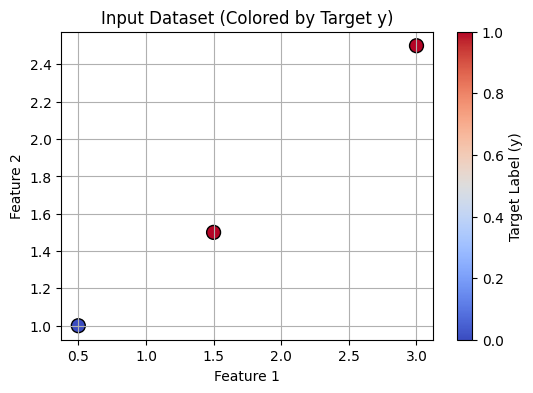

In [3]:
# Synthetic dataset: X contains input features, y contains target labels
X = torch.tensor([[0.5, 1.0],
                  [1.5, 1.5],
                  [3.0, 2.5]], dtype=torch.float32)

# Target labels (0 or 1 for binary classification type problems)
y = torch.tensor([[0.0],
                  [1.0],
                  [1.0]], dtype=torch.float32)

print("Input data X:")
print(X)
print("\nTarget data y:")
print(y)

# Visualize the input dataset
plt.figure(figsize=(6, 4))
scatter_y = y.squeeze().numpy() # Use y for color if available and meaningful
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=scatter_y, cmap='coolwarm', s=100, edgecolor='k')
plt.title('Input Dataset (Colored by Target y)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Target Label (y)')
plt.grid(True)
plt.show()

## Passo 4: Instanciando o modelo e inspecionando os pesos iniciais

Na célula de código  abaixo cria uma rede neural simples chamada `Model`.
- Ele imprime a estrutura do modelo e captura os pesos (*weights*) e o viés (*bias*) iniciais. Esses modelos são apenas "palpites iniciais" antes de qualquer treinamento. 
- A saída mostra que criamos uma rede neural muito simples.
    - Ela recebe dois valores de entrada (como altura e peso), produz uma saída (como sim ou não) e inclui um termo de viés.
    - Os valores iniciais (pesos 0.5406 e 0.5869 e viés 0.1657) são totalmente aleatórios no momento; é apenas por onde o modelo começa a aprender.  

In [4]:
model = SimpleNN()

print("\nModel architecture:")
print(model)

initial_weights = model.fc1.weight.data.clone() # Store a copy for plotting
initial_bias = model.fc1.bias.data.clone()     # Store a copy for plotting

print("\nInitial weights of fc1:")
print(initial_weights)
print("\nInitial bias of fc1:")
print(initial_bias)


Model architecture:
SimpleNN(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)

Initial weights of fc1:
tensor([[0.5406, 0.5869]])

Initial bias of fc1:
tensor([-0.1657])


Na célula de código abaixo, vamos visualizar a função `sigmoid`.

- Esta função espreme qualquer número entre 0 e 1, permitindo que o modelo tome decisões baseadas em probabilidades. - O código desenha uma linha mostrando como o modelo não treinado separa atualmente a classe 0 da classe 1. 

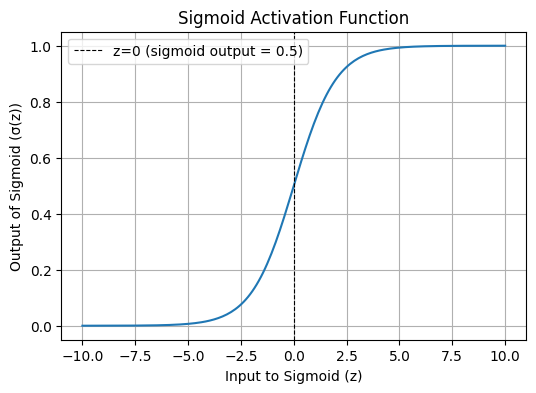

In [5]:
# Visualize the Sigmoid Activation Function
plt.figure(figsize=(6, 4))
z_vals = torch.linspace(-10, 10, 200)
sigmoid_vals = torch.sigmoid(z_vals)
plt.plot(z_vals.numpy(), sigmoid_vals.numpy())
plt.title('Sigmoid Activation Function')
plt.xlabel('Input to Sigmoid (z)')
plt.ylabel('Output of Sigmoid (σ(z))')
plt.grid(True)
plt.axvline(0, color='black', linestyle='--', lw=0.8, label='z=0 (sigmoid output = 0.5)')
plt.legend()
plt.show()

- No gráfico gerado pela célula abaixo a linha tracejada vermelha indica o "ponto de virada" (50/50) 
    - Ela é apenas o palpite inicial do modelo.
    - O modelo ainda não aprendeu, e está apenas supondo baseado em números aleatórios.

- Você também verá pontos cinzas de exemplo; o modelo ainda não aprendeu a classificá-los, mas chegaremos lá no treinamento.

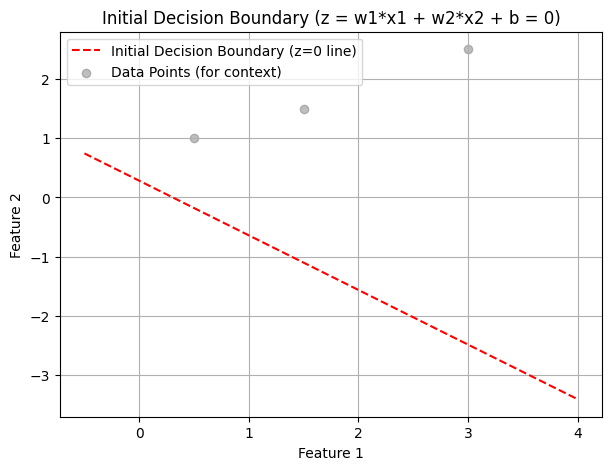

In [6]:
# Visualize the initial decision boundary (where input to sigmoid is 0)
fig_boundary_init, ax_boundary_init = plt.subplots(figsize=(7, 5))
plot_decision_boundary(X, initial_weights, initial_bias, ax_boundary_init, 'Initial Decision Boundary')
ax_boundary_init.set_title('Initial Decision Boundary (z = w1*x1 + w2*x2 + b = 0)')
plt.show()

## Passo 5: Forward Pass (Raw Output)

Agora, vamos realizar um **forward pass** para ver como nossa rede neural transforma entradas em saídas.

Pra fazer isso você:
- Coloca o modelo em modo de avaliação (`model_instance.eval()`) e desativa o cálculo de gradientes (`with torch.no_grad()`).
- Calcula as saídas do modelo para `X_data` (saídas já passando pela função sigmoid).
- Para cada amostra em `X_data`:
    - Recupera a entrada e a saída sigmoide.
    - Recalcula o valor pré-sigmoid (z = w·x + b) usando `model_instance.fc1(input.unsqueeze(0))` para inspeção.
    - Imprime: Input, Pre-Sigmoid e Sigmoid Output.
- Retorna o tensor com as saídas sigmoide e armazena-o em `model_outputs_after_sigmoid`.

In [7]:
def visualize_forward_pass_predictions(model_instance, X_data):
    model_instance.eval()
    with torch.no_grad():
        raw_outputs = model_instance(X_data) # These are already sigmoid outputs

    print("\n--- Forward Pass Visualization (Sigmoid Outputs) ---")
    for i in range(X_data.shape[0]):
        input_sample = X_data[i]
        output_prediction = raw_outputs[i]
        # Also show the input to the sigmoid
        with torch.no_grad(): # Recalculate pre-sigmoid for inspection
            pre_sigmoid_output = model_instance.fc1(input_sample.unsqueeze(0))

        print(f"Input: {input_sample.numpy()} -> Pre-Sigmoid: {pre_sigmoid_output.item():.4f} -> Sigmoid Output: {output_prediction.item():.4f}")
    return raw_outputs

model_outputs_after_sigmoid = visualize_forward_pass_predictions(model, X)


--- Forward Pass Visualization (Sigmoid Outputs) ---
Input: [0.5 1. ] -> Pre-Sigmoid: 0.6916 -> Sigmoid Output: 0.6663
Input: [1.5 1.5] -> Pre-Sigmoid: 1.5256 -> Sigmoid Output: 0.8214
Input: [3.  2.5] -> Pre-Sigmoid: 2.9234 -> Sigmoid Output: 0.9490


## Passo 6: Plotando a entrada vs. saída

Vamos ver o que nosso modelo está pensando através do gráfico gerado abaixo.

- O gráfico mostra nossos pontos de dados coloridos pela previsão do modelo.
    - Quanto mais amarelo, mais confiante o modelo está na classe 1;
    - o roxo/azul escuro significa tendência para a classe 0.
    
Note como as cores ficam progressivamente mais "quentes" (amarelas) conforme nos movemos para o canto superior direito.

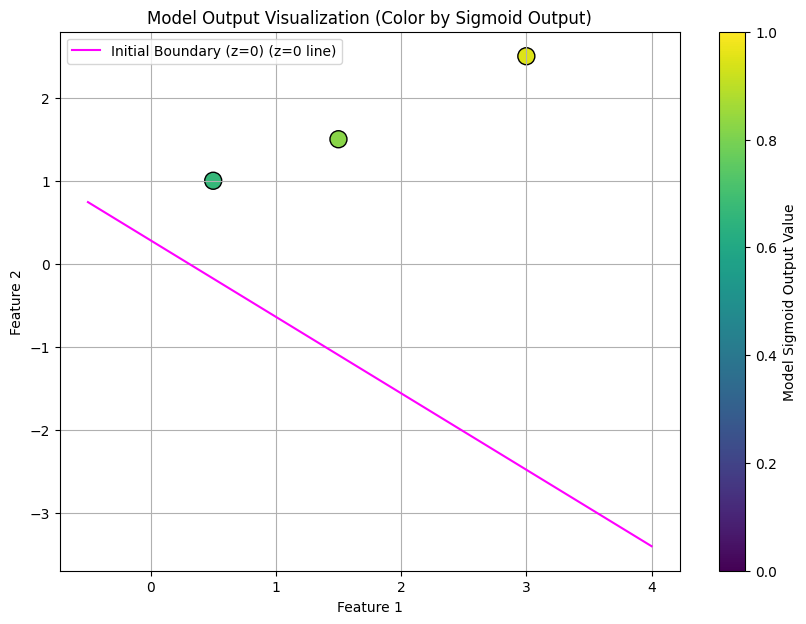

In [8]:
# model_outputs_after_sigmoid are the outputs from the sigmoid function.
plot_outputs_np = model_outputs_after_sigmoid.numpy()

plt.figure(figsize=(10, 7)) # Made figure larger for clarity
# Scatter plot of the input features X[:, 0] and X[:, 1]
# The color of each point is determined by the model's sigmoid output value
scatter = plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=plot_outputs_np, cmap='viridis', s=150, edgecolor='k', vmin=0, vmax=1)

plt.title('Model Output Visualization (Color by Sigmoid Output)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter, label='Model Sigmoid Output Value')
plt.grid(True)

# Overlay the initial decision boundary (z=0 line) on this plot for context
# We need to pass the current axes to the plotting function
current_ax = plt.gca()
plot_decision_boundary(X, initial_weights, initial_bias, current_ax, 'Initial Boundary (z=0)', linestyle='-', color='magenta', show_points=False)

plt.show()


## Passo 7: Plotando a fronteira do modelo

Este bloco final cria uma visualização abrangente, mostrando como as previsões variam em todo o espaço de recursos com um mapa de calor.
- A linha rosa é o palpite atual da fronteira. 

- O significado real está nas cores de fundo:
    - áreas verde/amarelas indicam maior probabilidade de classe 1,
    - áreas azuis indicam classe 0.
- É como um mapa de calor do "cérebro" do modelo.

- Uma vez que treinarmos o modelo, este mapa mudará e se tornará muito mais inteligente.

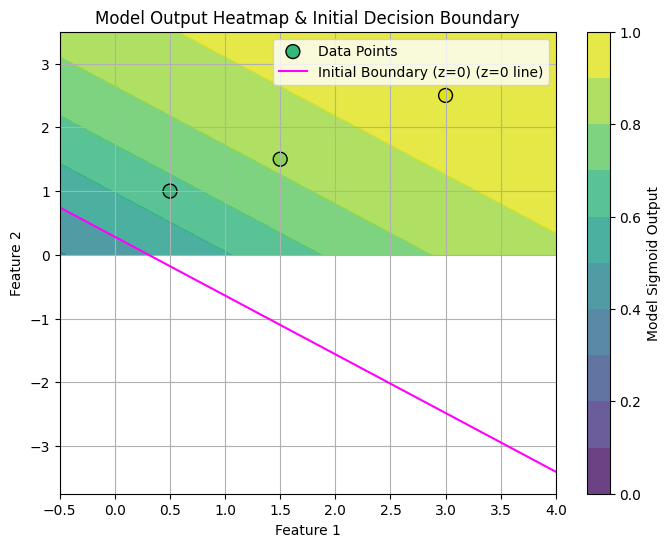

In [9]:
model.eval()
with torch.no_grad():
    # Create a grid of points
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                           np.linspace(x2_min, x2_max, 100))

    # Convert grid to PyTorch tensor
    grid_tensor = torch.tensor(np.c_[xx1.ravel(), xx2.ravel()], dtype=torch.float32)

    # Get model predictions for each point on the grid
    grid_predictions = model(grid_tensor).reshape(xx1.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(xx1, xx2, grid_predictions.numpy(), cmap='viridis', alpha=0.8, levels=np.linspace(0,1,11))
plt.colorbar(contour, label='Model Sigmoid Output')
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=plot_outputs_np.squeeze(), cmap='viridis', s=100, edgecolor='k', vmin=0, vmax=1, label='Data Points')
# Overlay the decision boundary (z=0 line)
plot_decision_boundary(X, initial_weights, initial_bias, plt.gca(), 'Initial Boundary (z=0)', linestyle='-', color='magenta', show_points=False)
plt.title('Model Output Heatmap & Initial Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Acabamos de construir uma rede neural do zero, e visualizamos seu processo de tomada de decisão.

Vimos como o *forward pass* transforma recursos em previsões através de pesos, vieses e da função de ativação. 

No próximo laboratório, exploraremos como treinar nossa rede para ajustar esses parâmetros.